# Trabajo final: SkinTone

## Importo Librerias

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import numpy.linalg as linalg
import imageio, math, copy, json, glob, os.path
from skimage import color
import tqdm

def mostrarImagen(img):
    plt.imshow(img)
    plt.show()

## Importo Json

In [31]:
f = open('CasualConversations/CasualConversations.json')
data = json.load(f)

## Detección de ROI de cara (OpenCV)

In [25]:
# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def detectFace(colorImg, DEBUG=False):
    
    # Convert to grayscale
    gray = cv2.cvtColor(colorImg, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_cascade.detectMultiScale3(gray, 1.1, 10, outputRejectLevels = True)
    
    if len(faces[0]) == 0:
        raise ValueError('No se encontró cara')

    face = faces[0][np.argmax(faces[2])]

    (x, y, w, h) = face
    cuttedImg = colorImg[y:y+h, x:x+w]

    if DEBUG:
        plt.imshow(cuttedImg)
        plt.show()
    
    return cuttedImg

## Algoritmo propuesto

In [26]:
def skinThreshold(img, DEBUG=False):
    endImage = copy.deepcopy(img)
    imgYCbCr = color.rgb2ycbcr(img)
    endImage[(imgYCbCr[:,:,2] < 136) | (imgYCbCr[:,:,2] > 173) | (imgYCbCr[:,:,1] < 77) | (imgYCbCr[:,:,1] > 127)] = [0,0,0]

    if DEBUG:
        plt.imshow(endImage)
        plt.show()
    return endImage

In [41]:
def calcITA(img, DEBUG=False):
    #Calculamos el promedio de los valores de piel
    arr = np.reshape(img,(len(img)*len(img[0]),3))
    arr = arr[np.any(arr != [0,0,0], axis=1)]
    
    if len(arr) == 0:
        raise ValueError('No se encontró piel')
    
    mean = np.mean(arr,0)
    
    if DEBUG:
        plt.imshow([[[int(mean[0]),int(mean[1]),int(mean[2])]]])
        plt.show()

    #D65 o D50
    [L, a, b] = color.rgb2lab(mean/255, illuminant='D50')
    
    return np.arctan((L-50)/b)*180/np.pi

In [28]:
def calcSkinTypeWithITA(v):
    if v >= 50:
        return 1
    if 25 <= v and v < 50:
        return 2
    if 0 <= v and v < 25:
        return 3
    if -25 <= v and v < 0:
        return 4
    if -50 <= v and v < -25:
        return 5
    if v < -50:
        return 6

In [32]:
def calcSkinType(img, DEBUG):
    faceImage = detectFace(img, DEBUG=DEBUG)
    skinFaceImage = skinThreshold(faceImage, DEBUG=DEBUG)
    v = calcITA(skinFaceImage, DEBUG=DEBUG)
    return calcSkinTypeWithITA(v)

In [44]:
DEBUG=False
results = []
errors = []
for key in tqdm.tqdm(data):
    for filePath in data[key]['files']:
        isDarkImage = filePath in data[key]['dark_files']
        filePath = ''.join(filePath.split('.')[:-1]) + '_orig.jpg'
        folder = '/'.join(filePath.split('/')[:-1]);
        imageName = filePath.split('/')[-1]; 
        try:
            img = imageio.imread('CasualConversations/ipdi/'+filePath)
            try:
                skinType = calcSkinType(img, DEBUG=DEBUG)
                if DEBUG:
                    print("skinType:" + str(skinType) + " verdadero: " + data[key]['label']['skin-type'])
                results.append([
                    folder,imageName,skinType,
                    int(data[key]['label']['skin-type']),
                    data[key]['label']['age'],data[key]['label']['gender'], isDarkImage
                ])
            except ValueError as err:
                errors.append(str(err) + " " + filePath)
        except FileNotFoundError:
            errors.append("Imagen no encontrada " + filePath)

f = open('errors.log','w')
f.write('\n'.join(errors))
f.close()

100%|██████████| 3011/3011 [14:11<00:00,  3.53it/s]


In [48]:
if not os.path.isfile("resultados.csv"):
    #Paso los datos a un dataframe
    dfResults = pd.DataFrame(results, columns=['folder','image','prediction','label','age','gender','dark'])
    dfResults.to_csv("resultados.csv")
else:
    #Cargar datos ya calculados
    dfResults = pd.read_csv("resultados.csv", index_col=0)

---
## Análisis

In [81]:
dfResultsGrouped = dfResults.groupby('folder').mean('prediction')
dfResultsGrouped['prediction'] = dfResultsGrouped['prediction'].round()
dfResultsGrouped['label'] = dfResultsGrouped['label'].astype('int64')

dfResultsGroupedBright = dfResults[dfResults['dark'] == False].groupby('folder').mean('prediction')
dfResultsGroupedBright['prediction'] = dfResultsGroupedBright['prediction'].round().astype('int64')
dfResultsGroupedBright['label'] = dfResultsGroupedBright['label'].astype('int64')


dfResultsGroupedDark = dfResults[dfResults['dark'] == True].groupby('folder').mean('prediction')
dfResultsGroupedDark['prediction'] = dfResultsGroupedDark['prediction'].round().astype('int64')
dfResultsGroupedDark['label'] = dfResultsGroupedDark['label'].astype('int64')

display(dfResultsGrouped.head(5))

prediction  label   age      dark
folder                                                      
CasualConversationsA/1140         6.0      5  33.0  0.200000
CasualConversationsA/1141         4.0      2  37.0  0.166667
CasualConversationsA/1142         3.0      6  31.0  0.181818
CasualConversationsA/1143         6.0      3  33.0  0.000000
CasualConversationsA/1144         2.0      6  40.0  0.000000

In [50]:
skinTypes = [1,2,3,4,5,6]

In [58]:
# Accuracy del método agrupando
acc = len(dfResultsGrouped[dfResultsGrouped['prediction'] == dfResultsGrouped['label']])/len(dfResultsGrouped)
print(acc)

acc = len(dfResultsGroupedBright[dfResultsGroupedBright['prediction'] == dfResultsGroupedBright['label']])/len(dfResultsGroupedBright)
print(acc)

acc = len(dfResultsGroupedDark[dfResultsGroupedDark['prediction'] == dfResultsGroupedDark['label']])/len(dfResultsGroupedDark)
print(acc)

# Acc tomando 1 como error
acc = len(dfResultsGrouped[(dfResultsGrouped['prediction'] == dfResultsGrouped['label']) | (dfResultsGrouped['prediction']+1 == dfResultsGrouped['label']) | (dfResultsGrouped['prediction']-1 == dfResultsGrouped['label'])])/len(dfResultsGrouped)
print(acc)

acc = len(dfResultsGroupedBright[(dfResultsGroupedBright['prediction'] == dfResultsGroupedBright['label']) | (dfResultsGroupedBright['prediction']+1 == dfResultsGroupedBright['label']) | (dfResultsGroupedBright['prediction']-1 == dfResultsGroupedBright['label'])])/len(dfResultsGroupedBright)
print(acc)

acc = len(dfResultsGroupedDark[(dfResultsGroupedDark['prediction'] == dfResultsGroupedDark['label']) | (dfResultsGroupedDark['prediction']+1 == dfResultsGroupedDark['label']) | (dfResultsGroupedDark['prediction']-1 == dfResultsGroupedDark['label'])])/len(dfResultsGroupedDark)
print(acc)

0.2617801047120419
0.2356020942408377
0.1702127659574468
0.5654450261780105
0.5706806282722513
0.45390070921985815


In [52]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Accuracy del método por skin-tone
accs = np.array([])
for s in skinTypes:
    acc = len(dfResultsGrouped[(dfResultsGrouped['prediction'] == dfResultsGrouped['label']) & (dfResultsGrouped['label'] == s)])/len(dfResultsGrouped[dfResultsGrouped['label'] == s])
    accs = np.append(accs,acc)

print(accs)

accs = np.array([])
for s in skinTypes:
    acc = len(dfResultsGroupedBright[(dfResultsGroupedBright['prediction'] == dfResultsGroupedBright['label']) & (dfResultsGroupedBright['label'] == s)])/len(dfResultsGroupedBright[dfResultsGroupedBright['label'] == s])
    accs = np.append(accs,acc)

print(accs)

accs = np.array([])
for s in skinTypes:
    acc = len(dfResultsGroupedDark[(dfResultsGroupedDark['prediction'] == dfResultsGroupedDark['label']) & (dfResultsGroupedDark['label'] == s)])/len(dfResultsGroupedDark[dfResultsGroupedDark['label'] == s])
    accs = np.append(accs,acc)

print(accs)


[0.125 0.121 0.222 0.143 0.361 0.463]
[0.125 0.091 0.250 0.095 0.278 0.439]
[0.267 0.000 0.074 0.111 0.032 0.625]


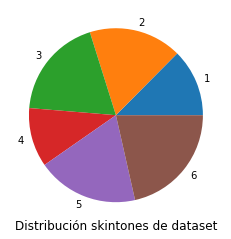

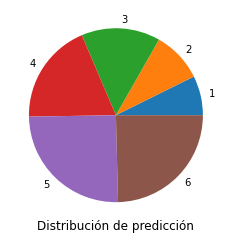

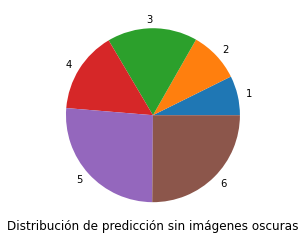

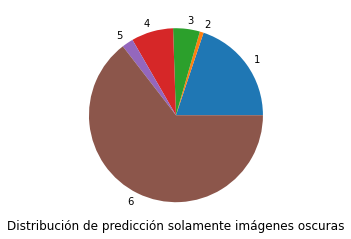

In [87]:
# Distribución skin-tones imagenes reales
porcentajesReales = []
for s in skinTypes:
    porcentaje = len(dfResultsGrouped[dfResultsGrouped['label'] == s])/len(dfResultsGrouped)
    porcentajesReales.append(porcentaje)

plt.pie(porcentajesReales, labels=skinTypes)
plt.title('Distribución skintones de dataset', y=-0.05)
plt.savefig("assets/porcentajes_skintones.svg")
plt.show()

# Distribución skin-tones imagenes predicciones
porcentajesPredict = []
for s in skinTypes:
    porcentaje = len(dfResultsGrouped[dfResultsGrouped['prediction'] == s])/len(dfResultsGrouped)
    porcentajesPredict.append(porcentaje)

plt.pie(porcentajesPredict, labels=skinTypes)
plt.title('Distribución de predicción', y=-0.05)
plt.savefig("assets/porcentajes_skintones_prediccion.svg")
plt.show()

# Distribución skin-tones imagenes predicciones sin dark
porcentajesPredictBright = []
for s in skinTypes:
    porcentaje = len(dfResultsGroupedBright[dfResultsGroupedBright['prediction'] == s])/len(dfResultsGroupedBright)
    porcentajesPredictBright.append(porcentaje)

plt.pie(porcentajesPredictBright, labels=skinTypes)
plt.title('Distribución de predicción sin imágenes oscuras', y=-0.05)
plt.savefig("assets/porcentajes_skintones_prediccion_sin_dark.svg")
plt.show()

# Distribución skin-tones imagenes predicciones dark
porcentajesPredictDark = []
for s in skinTypes:
    porcentaje = len(dfResultsGroupedDark[dfResultsGroupedDark['prediction'] == s])/len(dfResultsGroupedDark)
    porcentajesPredictDark.append(porcentaje)

plt.pie(porcentajesPredictDark, labels=skinTypes)
plt.title('Distribución de predicción solamente imágenes oscuras', y=-0.05)
plt.savefig("assets/porcentajes_skintones_prediccion_solo_dark.svg")
plt.show()

In [105]:
dfResultsGrouped['label'] - dfResultsGrouped['prediction'] <= 1

folder
CasualConversationsA/1140     True
CasualConversationsA/1141     True
CasualConversationsA/1142    False
CasualConversationsA/1143     True
CasualConversationsA/1144    False
                             ...  
CasualConversationsR/0127    False
CasualConversationsR/0129     True
CasualConversationsR/0192     True
CasualConversationsR/0499     True
CasualConversationsR/0519     True
Length: 191, dtype: bool

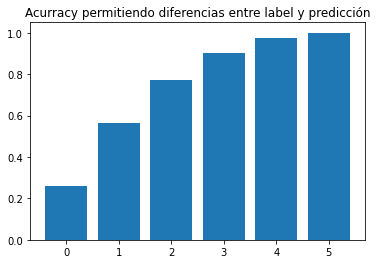

In [109]:
# Ver a donde se fue cada uno
ammounts = []
for i in [0,1,2,3,4,5]:
    ammounts.append(len(dfResultsGrouped[(dfResultsGrouped['label'] - dfResultsGrouped['prediction'] <= i) & (dfResultsGrouped['label'] - dfResultsGrouped['prediction'] >= -i)])/len(dfResultsGrouped)) 


plt.bar([0,1,2,3,4,5],ammounts)
plt.title('Acurracy permitiendo diferencias entre label y predicción')
plt.savefig("assets/differencias_prediccion.svg") 
plt.show()

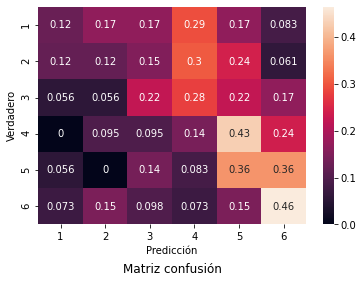

In [88]:
# Ver a donde se fue cada uno
confusionMatrix = np.zeros((6,6))
for line in dfResultsGrouped.iloc:
    confusionMatrix[int(line['label'])-1][int(line['prediction'])-1] += 1
for s in skinTypes:
    confusionMatrix[s-1,:] /= len(dfResultsGrouped[dfResultsGrouped['label'] == s])

df_cm = pd.DataFrame(confusionMatrix, range(1,6+1), range(1,6+1))
ax = sns.heatmap(df_cm, annot=True)
ax.set(ylabel='Verdadero', xlabel='Predicción')
ax.set_title('Matriz confusión', y=-0.25)
plt.savefig("assets/matriz_confusion.svg", bbox_inches="tight") 

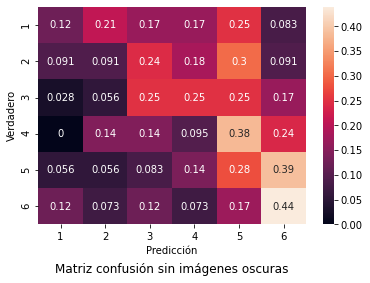

In [89]:
# Ver a donde se fue cada uno
confusionMatrix = np.zeros((6,6))
for line in dfResultsGroupedBright.iloc:
    confusionMatrix[line['label']-1][line['prediction']-1] += 1
for s in skinTypes:
    confusionMatrix[s-1,:] /= len(dfResultsGroupedBright[dfResultsGroupedBright['label'] == s])

df_cm = pd.DataFrame(confusionMatrix, range(1,6+1), range(1,6+1))
ax = sns.heatmap(df_cm, annot=True)
ax.set(ylabel='Verdadero', xlabel='Predicción')
ax.set_title('Matriz confusión sin imágenes oscuras', y=-0.25)
plt.savefig("assets/matriz_confusion_sin_dark.svg", bbox_inches="tight") 

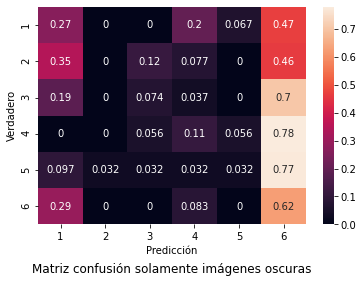

In [90]:
# Ver a donde se fue cada uno
confusionMatrix = np.zeros((6,6))
for line in dfResultsGroupedDark.iloc:
    confusionMatrix[line['label']-1][line['prediction']-1] += 1
for s in skinTypes:
    confusionMatrix[s-1,:] /= len(dfResultsGroupedDark[(dfResultsGroupedDark['label'] == s)])

df_cm = pd.DataFrame(confusionMatrix, range(1,6+1), range(1,6+1))
ax = sns.heatmap(df_cm, annot=True)
ax.set(ylabel='Verdadero', xlabel='Predicción')
ax.set_title('Matriz confusión solamente imágenes oscuras', y=-0.25)
plt.savefig("assets/matriz_confusion_solo_dark.svg", bbox_inches="tight") 

---
## Corrección de color

In [83]:
dfResults[dfResults['image'] == '1512_02_orig.jpg']

folder             image  prediction  label  age  \
1598  CasualConversationsH/1512  1512_02_orig.jpg           6      2  NaN   

      gender  dark  
1598  Female  True

In [136]:
def obtenerPromedioSeleccion(img):
    imgCopy = copy.deepcopy(img)
    roi = cv2.selectROI(windowName="roi", img=cv2.cvtColor(imgCopy, cv2.COLOR_RGB2BGR), showCrosshair=True, fromCenter=False)
    x, y, w, h = roi
    
    cv2.destroyAllWindows()

    cv2.rectangle(img=imgCopy, pt1=(x, y), pt2=(x + w, y + h), color=(0, 0, 255), thickness=2)
    mostrarImagen(imgCopy)

    cuttedRectangle = imgCopy[y:y+h,x:x+w]
    promedioFondo = np.array([int(np.mean(cuttedRectangle[:,:,0])), int(np.mean(cuttedRectangle[:,:,1])), int(np.mean(cuttedRectangle[:,:,2]))])
    mostrarImagen([[promedioFondo]])
    return promedioFondo

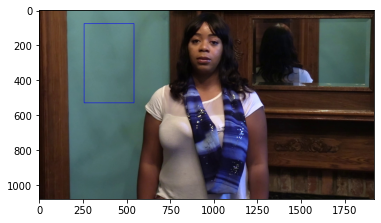

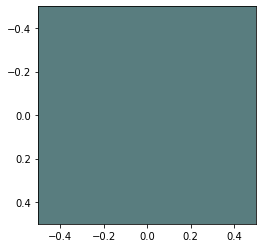

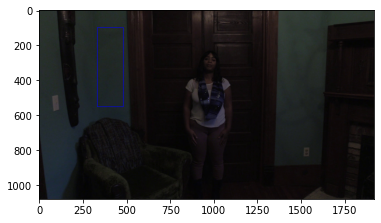

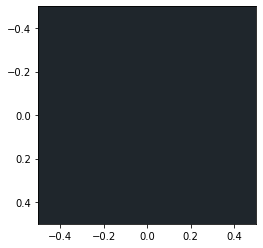

In [137]:
imgDarkExample = imageio.imread('CasualConversations/ipdi/CasualConversationsA/1140/1140_00_orig.jpg')
imgExample = imageio.imread('CasualConversations/ipdi/CasualConversationsA/1140/1140_01_orig.jpg')
promedioFondo = obtenerPromedioSeleccion(imgExample)
promedioFondoOscuro = obtenerPromedioSeleccion(imgDarkExample)

In [138]:
def corregirColor(img, promedioFondoOriginal, promedioFondoOscuro):
    factor = promedioFondo/promedioFondoOscuro
    copyImg = copy.deepcopy(img)
    R = copyImg[:,:,0]*factor[0]
    G = copyImg[:,:,1]*factor[1]
    B = copyImg[:,:,2]*factor[2]
    R[R > 255] = 255
    G[G > 255] = 255
    B[B > 255] = 255
    copyImg[:,:,0] = R
    copyImg[:,:,1] = G
    copyImg[:,:,2] = B

    return copyImg

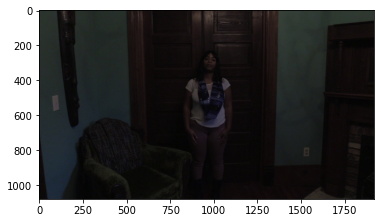

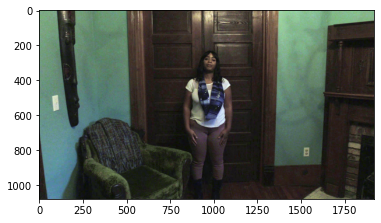

In [139]:
correctedImg = corregirColor(imgDarkExample, promedioFondo, promedioFondoOscuro)
mostrarImagen(imgDarkExample)
mostrarImagen(correctedImg)

imageio.imsave('assets/ejemplo_correccion_color_1.jpg',imgDarkExample)
imageio.imsave('assets/ejemplo_correccion_color_1_dark.jpg',correctedImg)

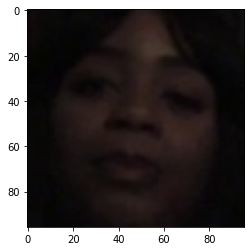

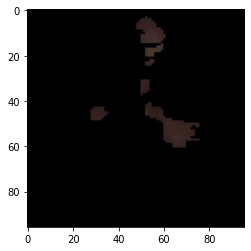

6


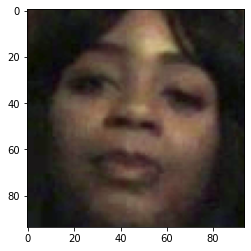

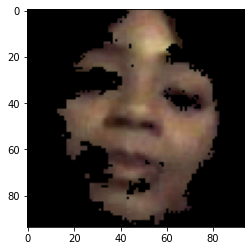

6


In [140]:
print(calcSkinType(imgDarkExample, True))
print(calcSkinType(correctedImg, True))

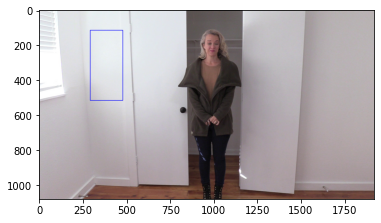

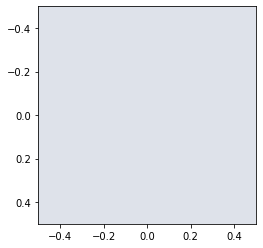

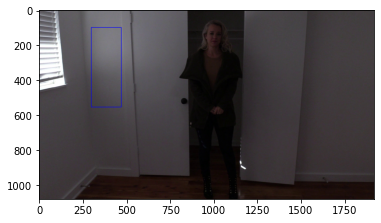

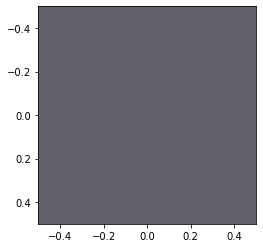

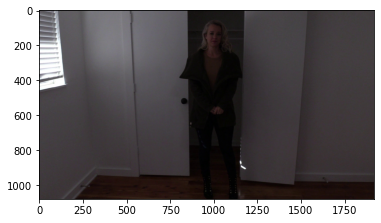

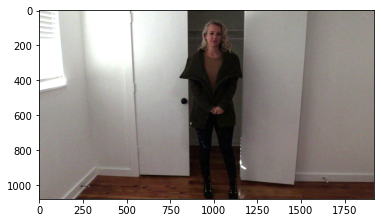

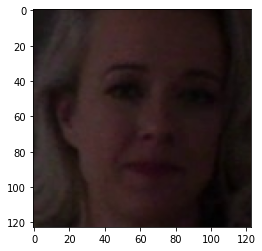

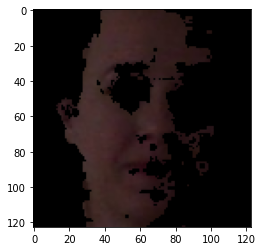

6


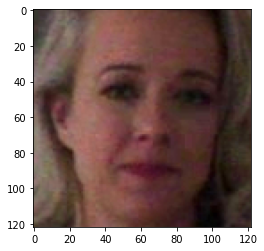

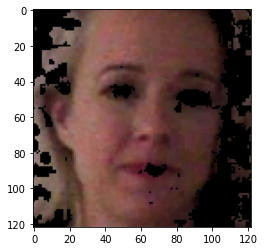

6


In [186]:
imgDarkExample = imageio.imread('CasualConversations/ipdi/CasualConversationsH/1512/1512_02_orig.jpg')
imgExample = imageio.imread('CasualConversations/ipdi/CasualConversationsH/1512/1512_01_orig.jpg')
promedioFondo = obtenerPromedioSeleccion(imgExample)
promedioFondoOscuro = obtenerPromedioSeleccion(imgDarkExample)
correctedImg = corregirColor(imgDarkExample, promedioFondo, promedioFondoOscuro)
mostrarImagen(imgDarkExample)
mostrarImagen(correctedImg)
imageio.imsave('assets/ejemplo_correccion_color_2.jpg',imgDarkExample)
imageio.imsave('assets/ejemplo_correccion_color_2_dark.jpg',correctedImg)
print(calcSkinType(imgDarkExample, True))
print(calcSkinType(correctedImg, True))

folder             image  prediction  label   age  \
1739  CasualConversationsM/0646  0646_00_orig.jpg           5      2  29.0   
1740  CasualConversationsM/0646  0646_02_orig.jpg           5      2  29.0   
1741  CasualConversationsM/0646  0646_03_orig.jpg           5      2  29.0   
1742  CasualConversationsM/0646  0646_04_orig.jpg           5      2  29.0   
1743  CasualConversationsM/0646  0646_05_orig.jpg           5      2  29.0   
1744  CasualConversationsM/0646  0646_06_orig.jpg           6      2  29.0   
1745  CasualConversationsM/0646  0646_07_orig.jpg           5      2  29.0   
1746  CasualConversationsM/0646  0646_10_orig.jpg           6      2  29.0   
1747  CasualConversationsM/0646  0646_11_orig.jpg           5      2  29.0   
1748  CasualConversationsM/0646  0646_12_orig.jpg           5      2  29.0   
1749  CasualConversationsM/0646  0646_13_orig.jpg           5      2  29.0   
1750  CasualConversationsM/0646  0646_14_orig.jpg           5      2  29.0   

     gender   dark  
1739    NaN  False  
1740    NaN  False  
1741    NaN  False  
1742    NaN  False  
1743    NaN  False  
1744    NaN   True  
1745    NaN  False  
1746    NaN   True  
1747    NaN  False  
1748    NaN   True  
1749    NaN  False  
1750    NaN  False

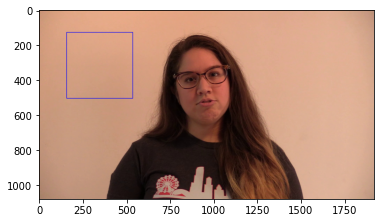

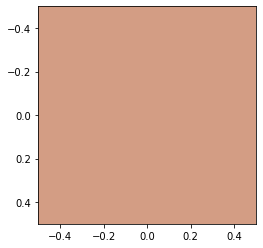

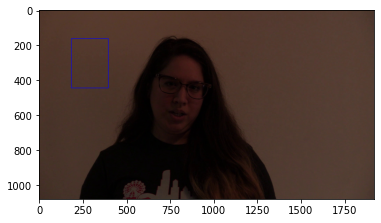

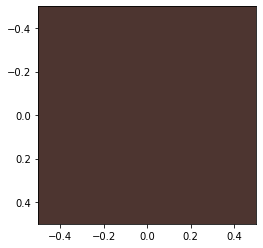

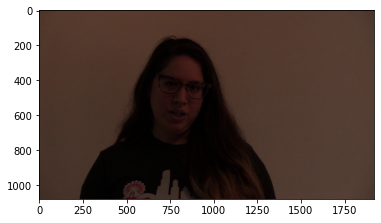

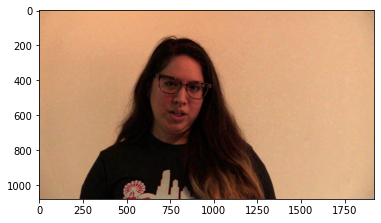

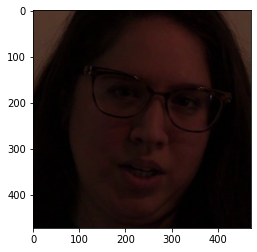

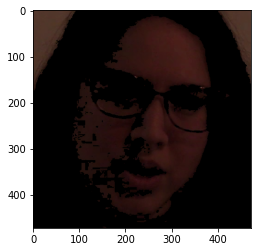

[50.213 23.518 19.655]
6


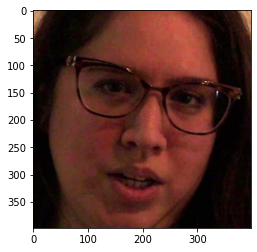

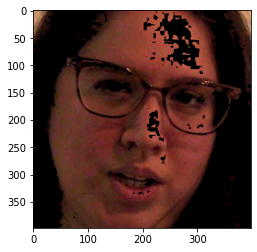

[100.352 46.218 35.862]
6


In [30]:
display(dfResults[dfResults['folder'] == 'CasualConversationsM/0646'])
imgDarkExample = imageio.imread('CasualConversations/ipdi/CasualConversationsM/0646/0646_06_orig.jpg')
imgExample = imageio.imread('CasualConversations/ipdi/CasualConversationsM/0646/0646_05_orig.jpg')
promedioFondo = obtenerPromedioSeleccion(imgExample)
promedioFondoOscuro = obtenerPromedioSeleccion(imgDarkExample)
correctedImg = corregirColor(imgDarkExample, promedioFondo, promedioFondoOscuro)
mostrarImagen(imgDarkExample)
mostrarImagen(correctedImg)
imageio.imsave('assets/ejemplo_correccion_color_3.jpg',imgDarkExample)
imageio.imsave('assets/ejemplo_correccion_color_3_dark.jpg',correctedImg)
print(calcSkinType(imgDarkExample, True))
print(calcSkinType(correctedImg, True))